Distribuzione delle classi:
 0    0.96682
1    0.03318
Name: proportion, dtype: float64
Axes(0.125,0.11;0.775x0.77)

Training XGBoost pipeline
Best parameters for XGBoost: {'classifier__n_estimators': 300, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.01}
Best score for XGBoost: 0.6568

Valutazione XGBoost sul test set:

--- Evaluation: XGBoost ---
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     14214
           1       0.23      0.78      0.35       488

    accuracy                           0.90     14702
   macro avg       0.61      0.84      0.65     14702
weighted avg       0.97      0.90      0.93     14702

Confusion Matrix:
[[12923  1291]
 [  109   379]]
Balanced Accuracy: 0.8429066990060596
F1 Macro: 0.6499337345655894
--------------------------------------------------------------------------------

Training Random Forest pipeline
Best parameters for Random Forest: {'classifier__n_esti

/home/achille/Desktop/ML/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for SVM: {'selector__k': 50, 'classifier__C': 0.1}
Best score for SVM: 0.6271

Valutazione SVM sul test set:

--- Evaluation: SVM ---
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.94     14214
           1       0.19      0.78      0.30       488

    accuracy                           0.88     14702
   macro avg       0.59      0.83      0.62     14702
weighted avg       0.96      0.88      0.91     14702

Confusion Matrix:
[[12578  1636]
 [  107   381]]
Balanced Accuracy: 0.8328199570038313
F1 Macro: 0.6196968344436818
--------------------------------------------------------------------------------

Training Logistic Regression pipeline
Best parameters for Logistic Regression: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__C': 10}
Best score for Logistic Regression: 0.6511

Valutazione Logistic Regression sul test set:

--- Evaluation: Logistic Regression ---
Classi

/tmp/ipykernel_56457/600352057.py:273: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1 Macro', y='Model', data=results_df.sort_values('F1 Macro', ascending=False), palette='viridis')


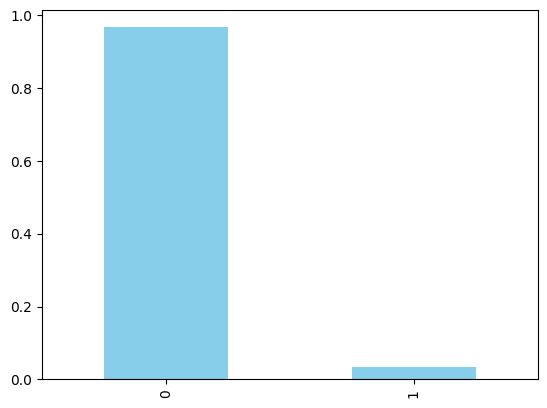

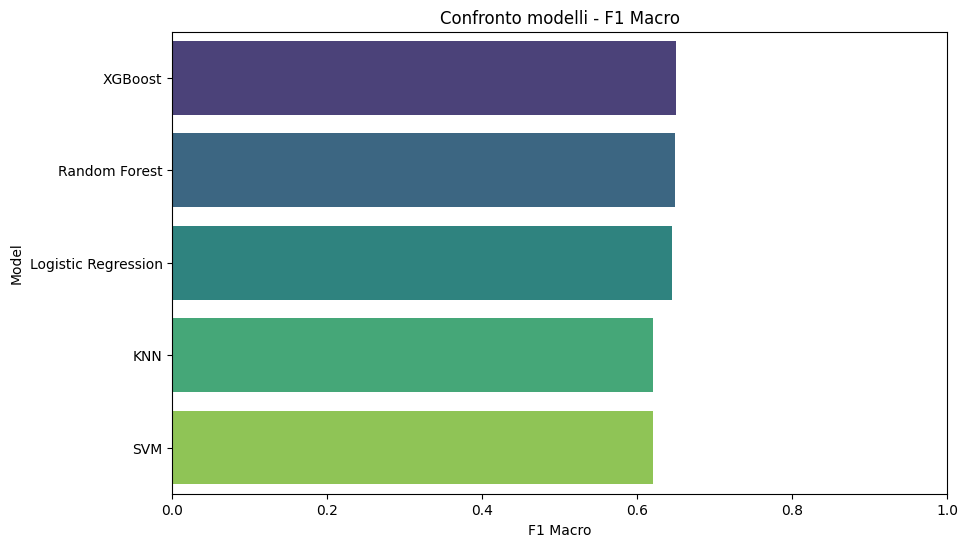

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE, SVMSMOTE
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
import logging
import datetime
from sklearn.feature_selection import VarianceThreshold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.feature_selection import mutual_info_classif


# Configurazione logging datetime
logging.basicConfig(
    filename=f"logs/model_evaluation_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.log",
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Funzione per valutazione del modello
def evaluate_model(model, X_test, y_test, model_name=""):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    matrix = confusion_matrix(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    log_msg = (
        f"\n--- Evaluation: {model_name} ---\n"
        f"Classification Report:\n{report}\n"
        f"Confusion Matrix:\n{matrix}\n"
        f"Balanced Accuracy: {bal_acc}\n"
        f"F1 Macro: {f1}\n"
        + "-"*80
    )
    
    logging.info(log_msg)
    print(log_msg)

# Pipeline 1: XGBoost 
def create_xgb_pipeline():
    pipeline = Pipeline([
        ('smote', BorderlineSMOTE(random_state=42)),
        ('varthresh', VarianceThreshold(threshold=1e-5)),
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(score_func=f_classif, k=100)),
        ('lda', LinearDiscriminantAnalysis(solver='svd')),
        ('classifier', XGBClassifier(eval_metric='mlogloss', random_state=42))
    ])
    
    param_dist = {
        #'selector__k': [10, 20, 30, 'all'],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 6, 10],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    }
    
    return pipeline, param_dist

# Pipeline 2: Random Forest
def create_rf_pipeline():
    pipeline = Pipeline([
        ('smote', BorderlineSMOTE(random_state=42)),
        ('varthresh', VarianceThreshold(threshold=1e-5)),
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(score_func=f_classif, k=100)),
        ('lda', LinearDiscriminantAnalysis(solver='svd', n_components=1)),
        ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
    ])
    
    param_dist = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 5, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    }
    
    return pipeline, param_dist

# Pipeline 3: SVM 
def create_svm_pipeline():
    pipeline = Pipeline([
        ('smote', BorderlineSMOTE(random_state=42)),
        ('varthresh', VarianceThreshold(threshold=1e-5)),
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(score_func=f_classif, k=100)),
        ('lda', LinearDiscriminantAnalysis(solver='svd', n_components=1)),
        ('classifier', SVC(random_state=42, class_weight='balanced', kernel='linear'))
    ])

    param_dist = {
        'selector__k': [50],
        'classifier__C': [0.1]
    }
    return pipeline, param_dist

# Pipeline 4: Logistic Regression 
def create_lr_pipeline():
    pipeline = Pipeline([
        ('smote', BorderlineSMOTE(random_state=42)),
        ('varthresh', VarianceThreshold(threshold=1e-5)),
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(score_func=f_classif, k=100)),
        ('lda', LinearDiscriminantAnalysis(solver='svd', n_components=1)),
        ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
    ])
    
    param_dist = {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga']
    }
    
    return pipeline, param_dist

# Pipeline 5: KNN
def create_knn_pipeline():
    pipeline = Pipeline([
        ('smote', BorderlineSMOTE(random_state=42)),
        ('varthresh', VarianceThreshold(threshold=1e-5)),
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(score_func=f_classif, k=100)),
        ('lda', LinearDiscriminantAnalysis(solver='svd', n_components=1)),
        ('classifier', KNeighborsClassifier())
    ])
    
    param_dist = {
        'classifier__n_neighbors': [3, 5, 7, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2]  # 1: manhattan, 2: euclidean
    }
    
    return pipeline, param_dist

def main():
    # Caricamento dati
    # take the csv int the previous directory
    df = pd.read_csv("../roi_features_train.csv")
    X = df.drop(columns=["image_id", "score", "x1", "y1", "x2", "y2", "label"])
    y = df["label"]

    # VOrrei fare una cosa del genere:
    # 1 - Globuli Rossi e Lucociti
    # 2 - Cellule infette

    # rimuovi classe 1
    # X = X[y != 1]
    # y = y[y != 1]

    # aggrega le classi 2, 3, 4 in una sola classe "2"
    y.replace({2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 1}, inplace=True)

    
    # Reset index after filtering
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y = le.fit_transform(y)
    

    
    # Analisi distribuzione classi
    print("Distribuzione delle classi:\n", pd.Series(y).value_counts(normalize=True))

    print(pd.Series(y).value_counts(normalize=True).plot(kind='bar', color='skyblue'))

    
    # selectkbest features
    # selector = SelectKBest(score_func=f_classif, k=100)
    # X_selected = selector.fit_transform(X, y)
    # print("Shape after SelectKBest:", X_selected.shape)
    # # Visualizzazione delle feature selezionate
    # plt.figure(figsize=(10, 6))
    
    

    # X_selected= X;
    # lda = LinearDiscriminantAnalysis(n_components=2)
    # X_lda = lda.fit_transform(X_selected, y)
    # print("LDA components shape:", X_lda.shape)

    # # pair plot di lda
    # lda_df = pd.DataFrame(X_lda, columns=['LD1', 'LD2'])
    # lda_df['label'] = y.values
    # sns.pairplot(lda_df, hue='label', palette='viridis')
    # plt.title("LDA Pair Plot")
    # plt.show()
    


    

    
    # Train-test split stratificato (senza feature selection per permettere a ogni pipeline di gestirla)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Lista di tutte le pipeline da sperimentare
    pipelines = [
        ("XGBoost", create_xgb_pipeline()),
        ("Random Forest", create_rf_pipeline()),
        ("SVM", create_svm_pipeline()),
        ("Logistic Regression", create_lr_pipeline()),
        ("KNN", create_knn_pipeline())
    ]

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    results = []

    for name, (pipeline, param_dist) in pipelines:
        print(f"\n{'='*40}")
        print(f"Training {name} pipeline")
        print(f"{'='*40}")
        
        search = RandomizedSearchCV(
            pipeline,
            param_distributions=param_dist,
            cv=3,
            scoring='f1_macro',
            n_iter=3,
            random_state=42,
            n_jobs=1  # usa 1 thread per vedere se il blocco è legato alla concorrenza
        )
        
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        #log the best parameters
        logging.info(f"Best parameters for {name}: {search.best_params_}")
        print(f"Best parameters for {name}: {search.best_params_}")
        print(f"Best score for {name}: {search.best_score_:.4f}")
        logging.info(f"Best score for {name}: {search.best_score_:.4f}")
        
        
        y_pred = best_model.predict(X_test)
        
        bal_acc = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        
        results.append({
            "Model": name,
            "Best Params": search.best_params_,
            "Balanced Accuracy": bal_acc,
            "F1 Macro": f1
        })
        
        print(f"\nValutazione {name} sul test set:")
        evaluate_model(best_model, X_test, y_test, model_name=name)

    # Output tabellare finale
    results_df = pd.DataFrame(results)
    print("\nConfronto Finale:")
    print(results_df.sort_values(by="F1 Macro", ascending=False))
    logging.info("\nConfronto Finale:\n" + str(results_df.sort_values(by="F1 Macro", ascending=False)))

    plt.figure(figsize=(10, 6))
    sns.barplot(x='F1 Macro', y='Model', data=results_df.sort_values('F1 Macro', ascending=False), palette='viridis')
    plt.title("Confronto modelli - F1 Macro")
    plt.xlim(0, 1)



if __name__ == "__main__":
    main()